# Calibrating the HMETS hydrological model using OSTRICH on the Raven server

Here we use birdy's WPS client to calibrate the HMETS hydrological model on the server and analyze the calibrated parameter set and hydrograph. 

In [1]:
from birdy import WPSClient

from example_data import TESTDATA
import datetime as dt
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os

# Set environment variable WPS_URL to "http://localhost:9099" to run on the default local server
url = os.environ.get("WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps")
wps = WPSClient(url)

In [2]:
# The model parameter boundaries. Can either be a string of comma separated values, a list, an array or a named tuple. 
lowerBounds = '0.3, 0.01, 0.5, 0.15, 0.0, 0.0, -2.0, 0.01, 0.0, 0.01, 0.005, -5.0, \
                      0.0, 0.0, 0.0, 0.0, 0.00001, 0.0, 0.00001, 0.0, 0.0'
upperBounds = '20.0, 5.0, 13.0, 1.5, 20.0, 20.0, 3.0, 0.2, 0.1, 0.3, 0.1, 2.0, 5.0, \
                      1.0, 3.0, 1.0, 0.02, 0.1, 0.01, 0.5, 2.0'
          
# Forcing files
ts=TESTDATA['ostrich-hmets-nc-ts']

# OSTRICH configuration parameters
config = dict(
    algorithm='DDS',
    max_iterations=10,
    area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    lowerbounds=lowerBounds,
    upperbounds=upperBounds,
    start_date=dt.datetime(1954, 1, 1),
    duration=208,
    # Comment out the random seed to show different results!
    random_seed=6.67408*10**-11,
    suppress_output=False,
    )

# Let's call Ostrich with the timeseries, calibration parameters and other configuration parameters
resp = wps.ostrich_hmets(ts=str(ts), **config)

# And get the response
# With `asobj` set to False, only the reference to the output is returned in the response. 
# Setting `asobj` to True will retrieve the actual files and copy the locally. 
[calibration, hydrograph, storage, solution, diagnostics, calibparams, rv] = resp.get(asobj=True)

Since we requested output objects, we can simply access the output objects. The dianostics is just a CSV file: 

In [3]:
print(calibparams)

18.06003, 3.510955, 11.9534, 1.413509, 16.62893, 34.57137, -0.2226484, 0.139122, 0.05429963, 0.2904521, 0.02706042, -4.562373, 0.6481391, 0.5493992, 2.509283, 0.421356, 0.0178487, 0.07768531, 0.004568809, 114.7092, 402.8124


The `hydrograph` and `storage` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools. 

In [4]:
hydrograph.q_sim

<xarray.DataArray 'q_sim' (time: 209, nbasins: 1)>
array([[  0.      ],
       [132.342029],
       [254.357644],
       ...,
       [ 88.478696],
       [122.117354],
       [160.636378]])
Coordinates:
  * time        (time) datetime64[ns] 1954-01-01 1954-01-02 ... 1954-07-28
    basin_name  (nbasins) object ...
Dimensions without coordinates: nbasins
Attributes:
    units:      m**3 s**-1
    long_name:  Simulated outflows

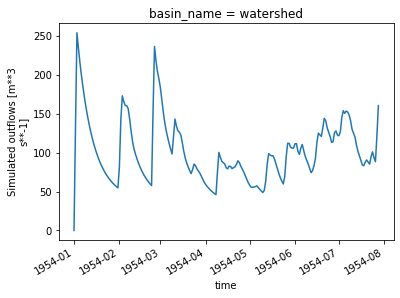

In [5]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

hydrograph.q_sim.plot()

In [6]:
print("Max: ", hydrograph.q_sim.max())
print("Mean: ", hydrograph.q_sim.mean())
print("Monthly means: ", hydrograph.q_sim.groupby('time.month').mean(dim='time'))

Max:  <xarray.DataArray 'q_sim' ()>
array(254.3576443)
Mean:  <xarray.DataArray 'q_sim' ()>
array(102.12207978)
Monthly means:  <xarray.DataArray 'q_sim' (month: 7, nbasins: 1)>
array([[112.83436712],
       [122.62511706],
       [105.9590156 ],
       [ 73.66921186],
       [ 76.18933914],
       [110.17983101],
       [116.07413332]])
Coordinates:
    basin_name  (nbasins) object ...
  * month       (month) int64 1 2 3 4 5 6 7
Dimensions without coordinates: nbasins


Now, let's do a test: let's run the model again using the same parameters and check to see that the NSE is the same. 

First, lets extract the diagnostics from the optimized run, giving the calibration NSE.

In [7]:
diagnostics

'observed data series,filename,DIAG_NASH_SUTCLIFFE,DIAG_RMSE,\nHYDROGRAPH,/tmp/pywps_process_uwbcdhyt/Salmon-River-Near-Prince-George_meteo_daily.nc,-2.2878,93.9472,\n'

Run the HMETS WPS:

In [8]:
# Model configuration parameters
config = dict(area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    start_date=dt.datetime(1954, 1, 1),
    duration=208,
             )
# Let's call the model with the timeseries, model parameters and other configuration parameters
resp = wps.raven_hmets(ts=str(ts), params=calibparams, **config)
[hydrograph, storage, solution, diagnostics2, rv2] = resp.get(asobj=True)

Now lets check to see if the diagnostics are the same.

In [9]:
diagnostics2

'observed data series,filename,DIAG_NASH_SUTCLIFFE,DIAG_RMSE,\nHYDROGRAPH,/tmp/pywps_process_z3dif4zk/Salmon-River-Near-Prince-George_meteo_daily.nc,-2.28789,93.9485,\n'